# Trivago Booking

## Abstract

The purpose of this report will be to use the Trivago Booking Data to classify hotel bookings into a possible canceled booking, or retained booking.

This can be used to gain insight into how and why bookings are canceled. This can also be used as a model to gain a marketing advantage, by advertisement targeting those who are more likely to retain their bookings, or saving money by not targeting the bookings that are most likely to cancel their bookings.

## Results

At the end of the project, we have a model witch can predict whether a booking will be canceled or not with an accuracy of 87 % in a dataset with a distribution of 37.04 % canceled bookings and 62.96 % retained bookings.
These are significant results witch can be useful for marketing towards customers, to increase booking retention, or to help a company focus on areas of improvement.

## Acknowledgments

The data was originally created and found by Nuno Antonio, Ana Almeida, and Luis Nunes for the following paper:

https://www.sciencedirect.com/science/article/pii/S2352340918315191

The data file used was gathered from a github repository ran by tidy tuesday, which was downloaded and cleaned by Thomas Mock and Antoine Bichat. This can be found here:

https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md

In [1]:
import pandas as pd
import numpy as np
from statistics import mode

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier

In [2]:
# loading the data
df = pd.read_csv('hotels.csv')

## First look into the data

In [3]:
# diplaying the dataframe in parts so I can see all columns
columns = df.columns

display(df[columns[:10]].head())
display(df[columns[10:20]].head())
display(df[columns[20:]].head())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults
0,Resort Hotel,0,342,2015,July,27,1,0,0,2
1,Resort Hotel,0,737,2015,July,27,1,0,0,2
2,Resort Hotel,0,7,2015,July,27,1,0,1,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2


,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type
0,0.0,0,BB,PRT,Direct,Direct,0,0,0,C
1,0.0,0,BB,PRT,Direct,Direct,0,0,0,C
2,0.0,0,BB,GBR,Direct,Direct,0,0,0,A
3,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A
4,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A


,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Data Preprocessing

In [5]:
# droping undesired columns
df.drop(['hotel', 'arrival_date_year', 'arrival_date_week_number',
         'arrival_date_day_of_month', 'reservation_status', 'reservation_status_date'], axis=1, inplace=True)

# droping agent and company beceause there is too many missing values
df.drop(['agent', 'company'], axis=1, inplace=True)

# filling 'children' missing values with the mean
df['children'] = df['children'].fillna(df['children'].mean())

# filling country missing values with the mode
df['country'] = df['country'].fillna(mode(df['country']))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_month              119390 non-null  object 
 3   stays_in_weekend_nights         119390 non-null  int64  
 4   stays_in_week_nights            119390 non-null  int64  
 5   adults                          119390 non-null  int64  
 6   children                        119390 non-null  float64
 7   babies                          119390 non-null  int64  
 8   meal                            119390 non-null  object 
 9   country                         119390 non-null  object 
 10  market_segment                  119390 non-null  object 
 11  distribution_channel            119390 non-null  object 
 12  is_repeated_gues

Here is the data that will we be using for the modeling. A few things to note:

+ This data has 119,390 total observations.
+ This data has been cleaned of any null values.
+ Excluding the is_canceled feature, there are 22 other features to be used for modeling.

Features that were removed:

+ hotel
    + This feature tended to bring the accuracy of the model down, in testing, so it was removed from the modeling data.
+ arrival_date_year
    + This feature does not logically make sense, as the goal is to predict future bookings cancelation status.
+ arrival_date_week_number
    + This feature does not logically make sense, as it too specific about the booking timeframe,
        + there could have been local events that could have effected the bookings, or other outside factors.
        + this feature also tended to bring the accuracy down in testing.
+ arrival_date_day_of_month
    + For the same reasons above, this is too specific, yet also too broad of a feature revolved around dates.
+ reservation_status
    + This feature is a direct representation of whether a booking is canceled or retained, it was removed.
+ reservation_status_date
    + This will have no correlation to future bookings.

## Exploratory Data Analysis

Lets start by doing a general analysis of the data as a whole.

### Basic Statistics

In [7]:
df.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


Here is a summary of the continuous data for the modelling data, a few important notes from this are:

+ Lead Time:
    + Has a min of 0, while a max of 737. Although the median lead time is 69. This suggests that 50% of customers have a lead time less than 69, and the other 50% have a lead time greater than 69.

+ Average Daily Rate:
    + It is unknown what currency this is calculated with.
    + The mininum value is -6.38, meaning either a customer was paid to book or this is a clerical error.
    + The max value is 5400 which is a starking difference from the mininum of -6.38.
    + The median value is 94.59, showing that 50% of people that book will spend under 94.59, while the other 50% will spend more than that.

+ Adults, Children, and Babies:
    + Here we can see that the median for all but Adults is 0, showing that over 50% of customers do not book with babies or children.
    + The 1st Quarter to 3rd Quarted for Adults is 2, this shows that at least 75% of the customers book with 2 Adults!

+ A vast majority of customers will not spend time in a waiting list.

+ Roughly only 25% of customers will have a special request.

+ Customers are more likely to book during weekdays, than weekends.

### Distribution of Features

In [8]:
num_canceled = len(df[df['is_canceled'] == 1])
num_not_canceled = len(df[df['is_canceled'] == 0])

prct_canceled = round(num_canceled / len(df) * 100, 2)
prct_not_canceled = round(num_not_canceled / len(df) * 100, 2)

print(f'''
Total: {len(df)}
Canceled: {num_canceled} | {prct_canceled} %
Not Canceled : {num_not_canceled} | {prct_not_canceled} %
''')


Total: 119390
Canceled: 44224 | 37.04 %
Not Canceled : 75166 | 62.96 %



### Duplicates

In [9]:
# chicking how many duplicates do we have
len([x for x in df.duplicated() if x == True])

32544

We have duplications in this dataset. This is likely due to a high volume of samples, and high similarity between booking customers. These will be left in the modeling data.

## Graphing of Features

### Graph Set 1

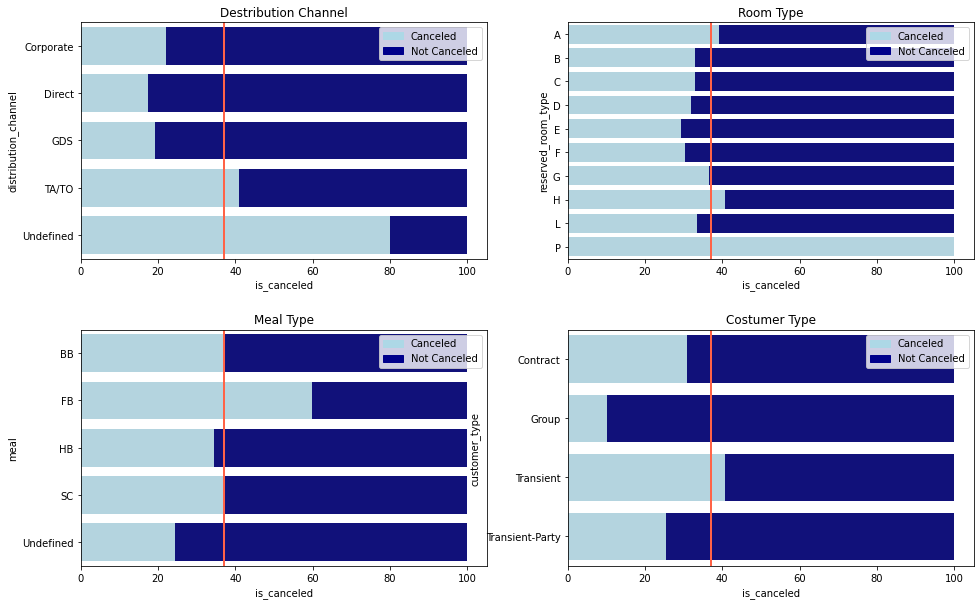

In [10]:
def plot_type1(feature, title):
    # from raw value to percentage
    total = df.groupby(feature, as_index=False)['is_canceled'].count()
    canceled = df[df['is_canceled'] == 1].groupby(feature, as_index=False)['is_canceled'].count()
    canceled['is_canceled'] = [i / j * 100 for i,j in zip(canceled['is_canceled'], total['is_canceled'])]
    total['is_canceled'] = [i / j * 100 for i,j in zip(total['is_canceled'], total['is_canceled'])]

    # plotting bars and the line representing the destribution
    bar1 = sns.barplot(x="is_canceled", y=feature, data=total, color='darkblue', orient='h')
    bar2 = sns.barplot(x="is_canceled", y=feature, data=canceled, color='lightblue', orient='h')
    plt.axvline(prct_canceled, lw=2, color='tomato')

    # add legend and title
    bottom_bar = mpatches.Patch(color='lightblue', label='Canceled')
    top_bar = mpatches.Patch(color='darkblue', label='Not Canceled')
    plt.legend(handles=[bottom_bar, top_bar])
    plt.title(title)


# set the figure size
plt.figure(figsize=(16, 10))


# plotting graph 1
plt.subplot(2, 2, 1)
plot_type1('distribution_channel', 'Destribution Channel')


# plotting graph 2
plt.subplot(2, 2, 2)
plot_type1('reserved_room_type', 'Room Type')


# plotting graph 3
plt.subplot(2, 2, 3)
plot_type1('meal', 'Meal Type')


# plotting graph 4
# subplot
plt.subplot(2, 2, 4)
plot_type1('customer_type', 'Costumer Type')


# adjusting subplots spacing
plt.subplots_adjust(hspace=0.3)

# show the graph
plt.show()

The red line in the graphs above represents the true split of customers that have not canceled (62.96%), in the modeling data.

These graphs show the proportion of features for the room type and meal type, as well as the distribution channel and the customer type. There are a few things that stand out:

+ The room types all seem to hover around the true split of cancellations, however the room type “P” is always canceled.
    + This could be due to an extremely low number of bookings for this room type.
+ Bookings made through Corporate, Direct, or GDS channels are typically kept, while TA/TO channels have roughly the usual proportion of cancelations.
+ Meal types all hover around the expected cancelation proportion, except for the “FB” or Full-Board type. Bookings made that have designated a Full-Board meal are typically canceled.
    + Also not that bookings with an Undefined meal type have the highest proportion of retained bookings.
+ While Contract and Transient bookings hover around the estimated cancelation proportions, it is apparant that bookings made for groups are usually retained!
    + This could be a good marketing avenue, targeting or pushing ads for group bookings to help retain bookings.
    + The Transient-Party customer type also tends to retain their bookings significantly more than expected.

### Graph Set 2

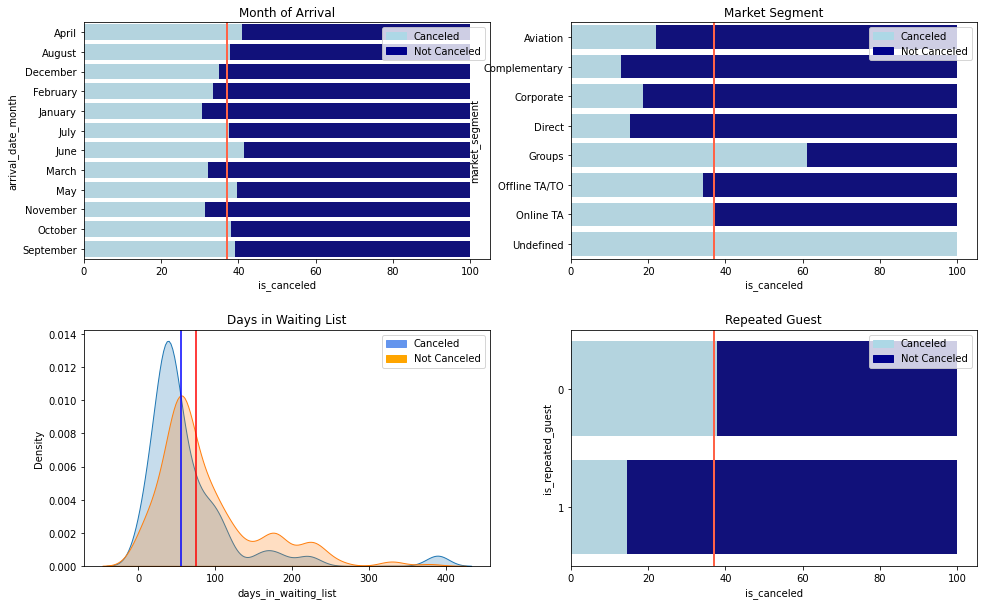

In [11]:
def plot_type2(feature, title, min_=float('-inf'), max_=float('inf'), mm=True):
    total = len(df)
    temp_df = df[(df[feature] > min_) & (df[feature] < max_)]
    canceled = temp_df[temp_df['is_canceled'] == 1][feature]
    not_canceled = temp_df[temp_df['is_canceled'] == 0][feature]

    # plot KDE
    sns.kdeplot(canceled, shade=True)
    sns.kdeplot(not_canceled, shade=True)

    # plot mean and median
    if mm == True:
        plt.axvline(np.mean(temp_df[feature]), color='r')
        plt.axvline(np.median(temp_df[feature]), color='b')

    # add legend and title
    bottom_bar = mpatches.Patch(color='cornflowerblue', label='Canceled')
    top_bar = mpatches.Patch(color='orange', label='Not Canceled')
    plt.legend(handles=[bottom_bar, top_bar])

    # title
    plt.title(title)


# set the figure size
plt.figure(figsize=(16, 10))


# plottiing graph 1
plt.subplot(2, 2, 1)
plot_type1('arrival_date_month', 'Month of Arrival')


# plottiing graph 2
plt.subplot(2, 2, 2)
plot_type1('market_segment', 'Market Segment')


# plottiing graph 3
plt.subplot(2, 2, 3)
plot_type2('days_in_waiting_list', 'Days in Waiting List', 0)


# plottiing graph 4
plt.subplot(2, 2, 4)
plot_type1('is_repeated_guest', 'Repeated Guest')

# adjusting subplots spacing
plt.subplots_adjust(hspace=0.3)

# show the graph
plt.show()

From these graphs there is a good amount of information we can extract:

+ The proportion of retained and canceled bookings seems to be relatively stable throughout the months.
    + However January has the highest proportion of retained bookins,
    + While June has the highest number of cancellations.
+ The market segment of bookings has some clear differences in the proportion of retained and canceled bookings.
    + Excluding Undefinned, Groups seems to be the only group far below the usualy 67% of reained bookings.
    + The Direct, Corporate, Complementary, and Aviation bookings tend to have the highest amount of retained bookings.
    + The TA/TO markets are right around the average proportion.
+ The number of days a customer spends in a waiting list generally has better effects.
    + This graph was heavily modified. Before at least 75% of bookings spend 0 days in a waiting list, so this is looking at all number of days greater than 0 to get a better insight.
+ The number of days a customer spends in a waiting list generally has better effects.
    + This graph was heavily modified, as shown before at least 75% of bookings spend 0 days in a waiting list, so this is looking at all number of days greater than 0 to get a better insight.
+ It is clearly shown that if a booking was made by a repeated guest, they are much more likely to retain the current booking.
    + However, if they are not a repeated guest the proportion of retained bookings is as expected.

### Graph Set 3

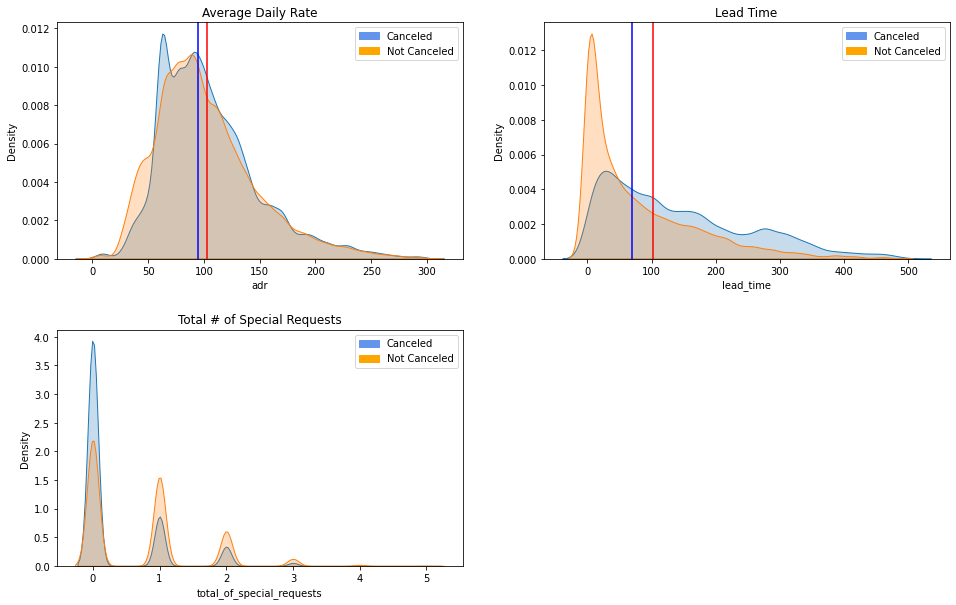

In [12]:
# set the figure size
plt.figure(figsize=(16, 10))


# plottiing graph 1
plt.subplot(2, 2, 1)
plot_type2('adr', 'Average Daily Rate', 0, 300)

# plottiing graph 2
plt.subplot(2, 2, 2)
plot_type2('lead_time', 'Lead Time', max_=500)

# plottiing graph 3
plt.subplot(2, 2, 3)
plot_type2('total_of_special_requests', 'Total # of Special Requests', mm=False)


# adjusting subplots spacing
plt.subplots_adjust(hspace=0.3)

# show the graph
plt.show()

+ The Average Daily Rate is nearly identical between canceled bookings, and retained bookings.
    + The extreme outliers were removed for this distribtuion, looking at ADRs’ above 0, and below 300.
+ Lead times are typically lower for retained bookings, this could suggest that the sooner the booking, the more likely the customer is to retain that booking.
    + The outliers were removed for this distribution. We are looking at the Lead Times less than 500 days.
+ Generally, bookings that require a special request are more likely to be retained, while if they do not require a special request, they are more likely to be canceled.
    + Outliers of requests more than 5 were excluded.

### Graph Set 4

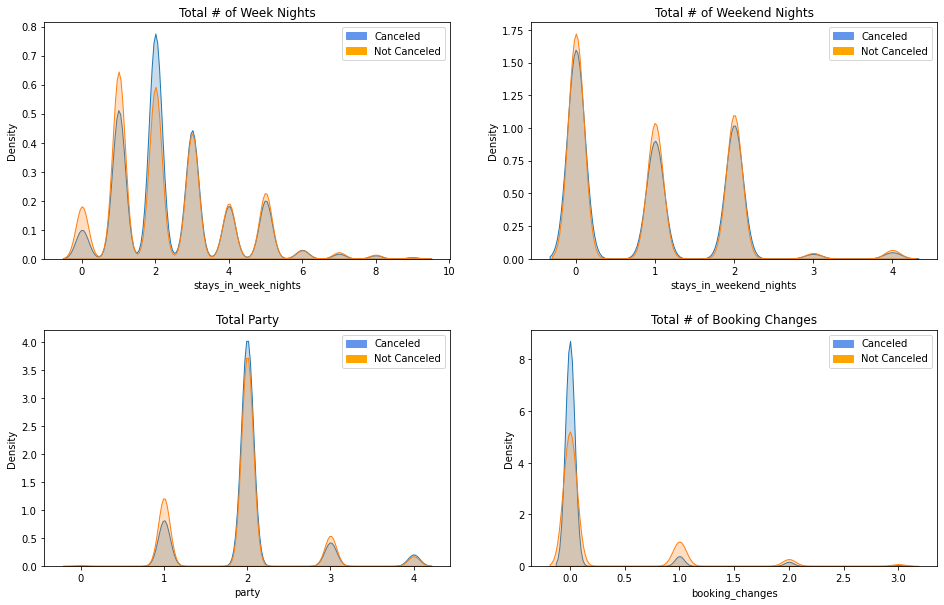

In [13]:
# set the figure size
plt.figure(figsize=(16, 10))


# plottiing graph 1
plt.subplot(2, 2, 1)
plot_type2('stays_in_week_nights', 'Total # of Week Nights', max_=10, mm=False)

# plottiing graph 2
plt.subplot(2, 2, 2)
plot_type2('stays_in_weekend_nights', 'Total # of Weekend Nights', max_=5, mm=False)

# plottiing graph 3
df['party'] = df['adults'] + df['children'] + df['babies']

plt.subplot(2, 2, 3)
plot_type2('party', 'Total Party', max_=5, mm=False)

df.drop('party', axis=1, inplace=True)

# plottiing graph 4
plt.subplot(2, 2, 4)
plot_type2('booking_changes', 'Total # of Booking Changes', max_=4, mm=False)


# adjusting subplots spacing
plt.subplots_adjust(hspace=0.3)

# show the graph
plt.show()

We can notice that majority customers that booked on the weekends did not cancel their bookings. It is also apparent that bookings made with only two week nights were more often canceled than retained.

+ This could suggest that it would be better to market towards weekend bookings, or bookings for more than 2 days, or bookings made for 1 day.
+ The total number of party members has little effect on cancellations,
    + However, bookings made for 1 party member are less likely to be canceled, while parties of 2 are more likely to be canceled.
    + Outliers of parties greater than 4 were removed.
+ If a booking is changed, there is a much higher chance that the booking will be retained, while if there are no changes, there seems to be more cancelations.
    + Outliers of bookings greater than 3 were removed.

# Modeling

The purpose of these models will be to predict whether the booking will bi canceled or not. This insight can be used for Market Targeting

In [14]:
# encoding categorical values
df = pd.get_dummies(df)

In [15]:
# spliting features and target
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [16]:
# shuffling the dataset and spliting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
# instantiating the model
model = CatBoostClassifier()

# testing for cross validation
score = cross_validate(model, X_train, y_train)

Learning rate set to 0.063836
0:	learn: 0.6391291	total: 197ms	remaining: 3m 16s
1:	learn: 0.5891468	total: 245ms	remaining: 2m 2s
2:	learn: 0.5537092	total: 272ms	remaining: 1m 30s
3:	learn: 0.5263626	total: 298ms	remaining: 1m 14s
4:	learn: 0.5034239	total: 322ms	remaining: 1m 4s
5:	learn: 0.4840467	total: 347ms	remaining: 57.5s
6:	learn: 0.4652943	total: 372ms	remaining: 52.8s
7:	learn: 0.4533337	total: 398ms	remaining: 49.4s
8:	learn: 0.4426445	total: 425ms	remaining: 46.8s
9:	learn: 0.4315777	total: 448ms	remaining: 44.3s
10:	learn: 0.4230692	total: 471ms	remaining: 42.4s
11:	learn: 0.4149252	total: 496ms	remaining: 40.8s
12:	learn: 0.4097910	total: 520ms	remaining: 39.5s
13:	learn: 0.4051200	total: 543ms	remaining: 38.2s
14:	learn: 0.4010838	total: 565ms	remaining: 37.1s
15:	learn: 0.3971065	total: 588ms	remaining: 36.2s
16:	learn: 0.3939456	total: 613ms	remaining: 35.5s
17:	learn: 0.3912124	total: 636ms	remaining: 34.7s
18:	learn: 0.3867371	total: 658ms	remaining: 34s
19:	learn:

162:	learn: 0.3177547	total: 2.98s	remaining: 15.3s
163:	learn: 0.3175355	total: 3s	remaining: 15.3s
164:	learn: 0.3174509	total: 3.01s	remaining: 15.3s
165:	learn: 0.3173452	total: 3.03s	remaining: 15.2s
166:	learn: 0.3172175	total: 3.04s	remaining: 15.2s
167:	learn: 0.3168319	total: 3.06s	remaining: 15.1s
168:	learn: 0.3167311	total: 3.07s	remaining: 15.1s
169:	learn: 0.3165522	total: 3.08s	remaining: 15.1s
170:	learn: 0.3163965	total: 3.1s	remaining: 15s
171:	learn: 0.3162248	total: 3.11s	remaining: 15s
172:	learn: 0.3159749	total: 3.13s	remaining: 15s
173:	learn: 0.3158140	total: 3.14s	remaining: 14.9s
174:	learn: 0.3156419	total: 3.16s	remaining: 14.9s
175:	learn: 0.3154779	total: 3.17s	remaining: 14.9s
176:	learn: 0.3154190	total: 3.19s	remaining: 14.8s
177:	learn: 0.3153637	total: 3.2s	remaining: 14.8s
178:	learn: 0.3152303	total: 3.22s	remaining: 14.8s
179:	learn: 0.3151192	total: 3.23s	remaining: 14.7s
180:	learn: 0.3149850	total: 3.24s	remaining: 14.7s
181:	learn: 0.3148514	t

328:	learn: 0.2985818	total: 5.37s	remaining: 11s
329:	learn: 0.2984303	total: 5.39s	remaining: 10.9s
330:	learn: 0.2982256	total: 5.4s	remaining: 10.9s
331:	learn: 0.2980524	total: 5.42s	remaining: 10.9s
332:	learn: 0.2979125	total: 5.43s	remaining: 10.9s
333:	learn: 0.2977715	total: 5.45s	remaining: 10.9s
334:	learn: 0.2976032	total: 5.46s	remaining: 10.8s
335:	learn: 0.2975329	total: 5.47s	remaining: 10.8s
336:	learn: 0.2974331	total: 5.49s	remaining: 10.8s
337:	learn: 0.2973243	total: 5.5s	remaining: 10.8s
338:	learn: 0.2972692	total: 5.51s	remaining: 10.8s
339:	learn: 0.2971450	total: 5.53s	remaining: 10.7s
340:	learn: 0.2970773	total: 5.54s	remaining: 10.7s
341:	learn: 0.2969481	total: 5.56s	remaining: 10.7s
342:	learn: 0.2968544	total: 5.58s	remaining: 10.7s
343:	learn: 0.2967933	total: 5.59s	remaining: 10.7s
344:	learn: 0.2967081	total: 5.6s	remaining: 10.6s
345:	learn: 0.2965956	total: 5.62s	remaining: 10.6s
346:	learn: 0.2965067	total: 5.63s	remaining: 10.6s
347:	learn: 0.296

495:	learn: 0.2871369	total: 7.75s	remaining: 7.88s
496:	learn: 0.2870740	total: 7.77s	remaining: 7.86s
497:	learn: 0.2870134	total: 7.78s	remaining: 7.85s
498:	learn: 0.2869259	total: 7.8s	remaining: 7.83s
499:	learn: 0.2868135	total: 7.81s	remaining: 7.81s
500:	learn: 0.2867483	total: 7.83s	remaining: 7.79s
501:	learn: 0.2865993	total: 7.84s	remaining: 7.78s
502:	learn: 0.2865285	total: 7.85s	remaining: 7.76s
503:	learn: 0.2865196	total: 7.87s	remaining: 7.74s
504:	learn: 0.2864618	total: 7.88s	remaining: 7.72s
505:	learn: 0.2863995	total: 7.89s	remaining: 7.71s
506:	learn: 0.2863256	total: 7.91s	remaining: 7.69s
507:	learn: 0.2863208	total: 7.92s	remaining: 7.67s
508:	learn: 0.2862632	total: 7.93s	remaining: 7.65s
509:	learn: 0.2862083	total: 7.95s	remaining: 7.64s
510:	learn: 0.2862035	total: 7.96s	remaining: 7.62s
511:	learn: 0.2860911	total: 7.98s	remaining: 7.6s
512:	learn: 0.2860414	total: 7.99s	remaining: 7.59s
513:	learn: 0.2860037	total: 8.01s	remaining: 7.57s
514:	learn: 0.

657:	learn: 0.2787186	total: 10.1s	remaining: 5.23s
658:	learn: 0.2786832	total: 10.1s	remaining: 5.21s
659:	learn: 0.2786783	total: 10.1s	remaining: 5.2s
660:	learn: 0.2786152	total: 10.1s	remaining: 5.18s
661:	learn: 0.2785392	total: 10.1s	remaining: 5.16s
662:	learn: 0.2785132	total: 10.1s	remaining: 5.15s
663:	learn: 0.2784825	total: 10.1s	remaining: 5.13s
664:	learn: 0.2784807	total: 10.2s	remaining: 5.12s
665:	learn: 0.2784168	total: 10.2s	remaining: 5.1s
666:	learn: 0.2783846	total: 10.2s	remaining: 5.08s
667:	learn: 0.2783422	total: 10.2s	remaining: 5.07s
668:	learn: 0.2783199	total: 10.2s	remaining: 5.05s
669:	learn: 0.2782919	total: 10.2s	remaining: 5.04s
670:	learn: 0.2782586	total: 10.2s	remaining: 5.02s
671:	learn: 0.2782068	total: 10.3s	remaining: 5s
672:	learn: 0.2782051	total: 10.3s	remaining: 4.99s
673:	learn: 0.2781546	total: 10.3s	remaining: 4.97s
674:	learn: 0.2781158	total: 10.3s	remaining: 4.96s
675:	learn: 0.2780770	total: 10.3s	remaining: 4.94s
676:	learn: 0.278

823:	learn: 0.2719105	total: 12.4s	remaining: 2.66s
824:	learn: 0.2717813	total: 12.5s	remaining: 2.64s
825:	learn: 0.2717572	total: 12.5s	remaining: 2.63s
826:	learn: 0.2717548	total: 12.5s	remaining: 2.61s
827:	learn: 0.2717267	total: 12.5s	remaining: 2.6s
828:	learn: 0.2716530	total: 12.5s	remaining: 2.58s
829:	learn: 0.2716517	total: 12.5s	remaining: 2.57s
830:	learn: 0.2716236	total: 12.5s	remaining: 2.55s
831:	learn: 0.2715696	total: 12.6s	remaining: 2.54s
832:	learn: 0.2715214	total: 12.6s	remaining: 2.52s
833:	learn: 0.2714690	total: 12.6s	remaining: 2.51s
834:	learn: 0.2714338	total: 12.6s	remaining: 2.49s
835:	learn: 0.2714057	total: 12.6s	remaining: 2.48s
836:	learn: 0.2713988	total: 12.6s	remaining: 2.46s
837:	learn: 0.2713525	total: 12.6s	remaining: 2.44s
838:	learn: 0.2713514	total: 12.7s	remaining: 2.43s
839:	learn: 0.2713134	total: 12.7s	remaining: 2.41s
840:	learn: 0.2713100	total: 12.7s	remaining: 2.4s
841:	learn: 0.2712783	total: 12.7s	remaining: 2.38s
842:	learn: 0.

987:	learn: 0.2659084	total: 14.9s	remaining: 180ms
988:	learn: 0.2658784	total: 14.9s	remaining: 165ms
989:	learn: 0.2658427	total: 14.9s	remaining: 150ms
990:	learn: 0.2657859	total: 14.9s	remaining: 135ms
991:	learn: 0.2657849	total: 14.9s	remaining: 120ms
992:	learn: 0.2657694	total: 14.9s	remaining: 105ms
993:	learn: 0.2657593	total: 14.9s	remaining: 90.2ms
994:	learn: 0.2657398	total: 15s	remaining: 75.2ms
995:	learn: 0.2656988	total: 15s	remaining: 60.1ms
996:	learn: 0.2656515	total: 15s	remaining: 45.1ms
997:	learn: 0.2656460	total: 15s	remaining: 30.1ms
998:	learn: 0.2655907	total: 15s	remaining: 15ms
999:	learn: 0.2655553	total: 15s	remaining: 0us
Learning rate set to 0.063836
0:	learn: 0.6359365	total: 27.3ms	remaining: 27.3s
1:	learn: 0.5928269	total: 41.2ms	remaining: 20.6s
2:	learn: 0.5533124	total: 55.3ms	remaining: 18.4s
3:	learn: 0.5212582	total: 69.8ms	remaining: 17.4s
4:	learn: 0.4995162	total: 84.6ms	remaining: 16.8s
5:	learn: 0.4819646	total: 98.4ms	remaining: 16.3

160:	learn: 0.3180088	total: 2.43s	remaining: 12.6s
161:	learn: 0.3179149	total: 2.44s	remaining: 12.6s
162:	learn: 0.3178101	total: 2.46s	remaining: 12.6s
163:	learn: 0.3177097	total: 2.47s	remaining: 12.6s
164:	learn: 0.3174985	total: 2.48s	remaining: 12.6s
165:	learn: 0.3172932	total: 2.5s	remaining: 12.6s
166:	learn: 0.3172417	total: 2.51s	remaining: 12.5s
167:	learn: 0.3171604	total: 2.53s	remaining: 12.5s
168:	learn: 0.3170548	total: 2.54s	remaining: 12.5s
169:	learn: 0.3169871	total: 2.56s	remaining: 12.5s
170:	learn: 0.3168950	total: 2.57s	remaining: 12.5s
171:	learn: 0.3167065	total: 2.58s	remaining: 12.4s
172:	learn: 0.3164819	total: 2.6s	remaining: 12.4s
173:	learn: 0.3163903	total: 2.61s	remaining: 12.4s
174:	learn: 0.3162311	total: 2.63s	remaining: 12.4s
175:	learn: 0.3161380	total: 2.64s	remaining: 12.4s
176:	learn: 0.3159306	total: 2.66s	remaining: 12.4s
177:	learn: 0.3158671	total: 2.67s	remaining: 12.3s
178:	learn: 0.3158039	total: 2.69s	remaining: 12.3s
179:	learn: 0.

322:	learn: 0.2990444	total: 4.79s	remaining: 10s
323:	learn: 0.2989201	total: 4.8s	remaining: 10s
324:	learn: 0.2988938	total: 4.82s	remaining: 10s
325:	learn: 0.2988388	total: 4.83s	remaining: 9.98s
326:	learn: 0.2987441	total: 4.85s	remaining: 9.97s
327:	learn: 0.2987119	total: 4.86s	remaining: 9.96s
328:	learn: 0.2986230	total: 4.88s	remaining: 9.94s
329:	learn: 0.2985311	total: 4.89s	remaining: 9.93s
330:	learn: 0.2985218	total: 4.9s	remaining: 9.91s
331:	learn: 0.2984466	total: 4.92s	remaining: 9.89s
332:	learn: 0.2984367	total: 4.93s	remaining: 9.87s
333:	learn: 0.2983462	total: 4.94s	remaining: 9.86s
334:	learn: 0.2982414	total: 4.96s	remaining: 9.84s
335:	learn: 0.2981409	total: 4.97s	remaining: 9.83s
336:	learn: 0.2980655	total: 4.99s	remaining: 9.81s
337:	learn: 0.2979281	total: 5s	remaining: 9.8s
338:	learn: 0.2978623	total: 5.02s	remaining: 9.79s
339:	learn: 0.2977824	total: 5.03s	remaining: 9.77s
340:	learn: 0.2976809	total: 5.05s	remaining: 9.76s
341:	learn: 0.2976625	to

483:	learn: 0.2880122	total: 7.14s	remaining: 7.61s
484:	learn: 0.2879769	total: 7.15s	remaining: 7.6s
485:	learn: 0.2879149	total: 7.17s	remaining: 7.58s
486:	learn: 0.2878616	total: 7.18s	remaining: 7.57s
487:	learn: 0.2877917	total: 7.2s	remaining: 7.55s
488:	learn: 0.2877297	total: 7.21s	remaining: 7.54s
489:	learn: 0.2876403	total: 7.23s	remaining: 7.52s
490:	learn: 0.2876139	total: 7.24s	remaining: 7.51s
491:	learn: 0.2875435	total: 7.25s	remaining: 7.49s
492:	learn: 0.2874841	total: 7.27s	remaining: 7.47s
493:	learn: 0.2874497	total: 7.28s	remaining: 7.46s
494:	learn: 0.2873234	total: 7.29s	remaining: 7.44s
495:	learn: 0.2872501	total: 7.31s	remaining: 7.43s
496:	learn: 0.2872112	total: 7.32s	remaining: 7.41s
497:	learn: 0.2871929	total: 7.34s	remaining: 7.4s
498:	learn: 0.2871328	total: 7.35s	remaining: 7.38s
499:	learn: 0.2870561	total: 7.37s	remaining: 7.37s
500:	learn: 0.2869372	total: 7.38s	remaining: 7.35s
501:	learn: 0.2868970	total: 7.4s	remaining: 7.34s
502:	learn: 0.28

647:	learn: 0.2793463	total: 9.54s	remaining: 5.18s
648:	learn: 0.2792604	total: 9.56s	remaining: 5.17s
649:	learn: 0.2792144	total: 9.57s	remaining: 5.15s
650:	learn: 0.2791355	total: 9.59s	remaining: 5.14s
651:	learn: 0.2790859	total: 9.6s	remaining: 5.12s
652:	learn: 0.2790007	total: 9.62s	remaining: 5.11s
653:	learn: 0.2789367	total: 9.63s	remaining: 5.09s
654:	learn: 0.2788806	total: 9.64s	remaining: 5.08s
655:	learn: 0.2788276	total: 9.66s	remaining: 5.06s
656:	learn: 0.2787507	total: 9.67s	remaining: 5.05s
657:	learn: 0.2786872	total: 9.69s	remaining: 5.04s
658:	learn: 0.2786335	total: 9.7s	remaining: 5.02s
659:	learn: 0.2786030	total: 9.72s	remaining: 5s
660:	learn: 0.2785436	total: 9.73s	remaining: 4.99s
661:	learn: 0.2784854	total: 9.75s	remaining: 4.98s
662:	learn: 0.2784552	total: 9.76s	remaining: 4.96s
663:	learn: 0.2784187	total: 9.77s	remaining: 4.95s
664:	learn: 0.2783841	total: 9.79s	remaining: 4.93s
665:	learn: 0.2783086	total: 9.8s	remaining: 4.92s
666:	learn: 0.2782

817:	learn: 0.2718917	total: 12s	remaining: 2.66s
818:	learn: 0.2718485	total: 12s	remaining: 2.64s
819:	learn: 0.2718107	total: 12s	remaining: 2.63s
820:	learn: 0.2717581	total: 12s	remaining: 2.62s
821:	learn: 0.2717402	total: 12s	remaining: 2.6s
822:	learn: 0.2717377	total: 12s	remaining: 2.58s
823:	learn: 0.2716883	total: 12s	remaining: 2.57s
824:	learn: 0.2716350	total: 12.1s	remaining: 2.56s
825:	learn: 0.2716051	total: 12.1s	remaining: 2.54s
826:	learn: 0.2715047	total: 12.1s	remaining: 2.53s
827:	learn: 0.2715034	total: 12.1s	remaining: 2.51s
828:	learn: 0.2714522	total: 12.1s	remaining: 2.5s
829:	learn: 0.2713935	total: 12.1s	remaining: 2.48s
830:	learn: 0.2713566	total: 12.1s	remaining: 2.47s
831:	learn: 0.2713286	total: 12.1s	remaining: 2.45s
832:	learn: 0.2713162	total: 12.2s	remaining: 2.44s
833:	learn: 0.2712793	total: 12.2s	remaining: 2.42s
834:	learn: 0.2712780	total: 12.2s	remaining: 2.41s
835:	learn: 0.2712446	total: 12.2s	remaining: 2.39s
836:	learn: 0.2712185	total:

978:	learn: 0.2660414	total: 14.3s	remaining: 307ms
979:	learn: 0.2659836	total: 14.3s	remaining: 292ms
980:	learn: 0.2659396	total: 14.3s	remaining: 278ms
981:	learn: 0.2659327	total: 14.3s	remaining: 263ms
982:	learn: 0.2659006	total: 14.4s	remaining: 248ms
983:	learn: 0.2658756	total: 14.4s	remaining: 234ms
984:	learn: 0.2658577	total: 14.4s	remaining: 219ms
985:	learn: 0.2658558	total: 14.4s	remaining: 204ms
986:	learn: 0.2657256	total: 14.4s	remaining: 190ms
987:	learn: 0.2657246	total: 14.4s	remaining: 175ms
988:	learn: 0.2656740	total: 14.4s	remaining: 161ms
989:	learn: 0.2656731	total: 14.4s	remaining: 146ms
990:	learn: 0.2656367	total: 14.5s	remaining: 131ms
991:	learn: 0.2656169	total: 14.5s	remaining: 117ms
992:	learn: 0.2655286	total: 14.5s	remaining: 102ms
993:	learn: 0.2655143	total: 14.5s	remaining: 87.6ms
994:	learn: 0.2654815	total: 14.5s	remaining: 73ms
995:	learn: 0.2654599	total: 14.5s	remaining: 58.4ms
996:	learn: 0.2654112	total: 14.6s	remaining: 43.8ms
997:	learn

146:	learn: 0.3198933	total: 2.23s	remaining: 12.9s
147:	learn: 0.3197373	total: 2.24s	remaining: 12.9s
148:	learn: 0.3196712	total: 2.26s	remaining: 12.9s
149:	learn: 0.3194809	total: 2.27s	remaining: 12.9s
150:	learn: 0.3192101	total: 2.29s	remaining: 12.9s
151:	learn: 0.3191466	total: 2.3s	remaining: 12.8s
152:	learn: 0.3190739	total: 2.32s	remaining: 12.8s
153:	learn: 0.3189463	total: 2.33s	remaining: 12.8s
154:	learn: 0.3188998	total: 2.35s	remaining: 12.8s
155:	learn: 0.3186792	total: 2.36s	remaining: 12.8s
156:	learn: 0.3184596	total: 2.38s	remaining: 12.8s
157:	learn: 0.3183843	total: 2.39s	remaining: 12.7s
158:	learn: 0.3183426	total: 2.4s	remaining: 12.7s
159:	learn: 0.3182487	total: 2.42s	remaining: 12.7s
160:	learn: 0.3180576	total: 2.43s	remaining: 12.7s
161:	learn: 0.3178508	total: 2.45s	remaining: 12.7s
162:	learn: 0.3177596	total: 2.46s	remaining: 12.6s
163:	learn: 0.3175389	total: 2.48s	remaining: 12.6s
164:	learn: 0.3173792	total: 2.49s	remaining: 12.6s
165:	learn: 0.

315:	learn: 0.3008606	total: 4.84s	remaining: 10.5s
316:	learn: 0.3008480	total: 4.86s	remaining: 10.5s
317:	learn: 0.3007671	total: 4.87s	remaining: 10.4s
318:	learn: 0.3007201	total: 4.89s	remaining: 10.4s
319:	learn: 0.3006195	total: 4.9s	remaining: 10.4s
320:	learn: 0.3006036	total: 4.91s	remaining: 10.4s
321:	learn: 0.3005993	total: 4.93s	remaining: 10.4s
322:	learn: 0.3005343	total: 4.94s	remaining: 10.4s
323:	learn: 0.3004598	total: 4.96s	remaining: 10.3s
324:	learn: 0.3003895	total: 4.97s	remaining: 10.3s
325:	learn: 0.3002913	total: 4.98s	remaining: 10.3s
326:	learn: 0.3002271	total: 5s	remaining: 10.3s
327:	learn: 0.3002226	total: 5.01s	remaining: 10.3s
328:	learn: 0.3000275	total: 5.03s	remaining: 10.2s
329:	learn: 0.2999171	total: 5.04s	remaining: 10.2s
330:	learn: 0.2998598	total: 5.06s	remaining: 10.2s
331:	learn: 0.2997545	total: 5.07s	remaining: 10.2s
332:	learn: 0.2996876	total: 5.08s	remaining: 10.2s
333:	learn: 0.2996381	total: 5.1s	remaining: 10.2s
334:	learn: 0.299

486:	learn: 0.2886774	total: 7.38s	remaining: 7.77s
487:	learn: 0.2886104	total: 7.39s	remaining: 7.75s
488:	learn: 0.2885383	total: 7.41s	remaining: 7.74s
489:	learn: 0.2884930	total: 7.42s	remaining: 7.72s
490:	learn: 0.2884841	total: 7.43s	remaining: 7.71s
491:	learn: 0.2884126	total: 7.45s	remaining: 7.69s
492:	learn: 0.2883669	total: 7.46s	remaining: 7.67s
493:	learn: 0.2883643	total: 7.48s	remaining: 7.66s
494:	learn: 0.2882906	total: 7.49s	remaining: 7.64s
495:	learn: 0.2882128	total: 7.51s	remaining: 7.63s
496:	learn: 0.2881587	total: 7.52s	remaining: 7.61s
497:	learn: 0.2880974	total: 7.54s	remaining: 7.59s
498:	learn: 0.2880502	total: 7.55s	remaining: 7.58s
499:	learn: 0.2880321	total: 7.57s	remaining: 7.57s
500:	learn: 0.2879517	total: 7.58s	remaining: 7.55s
501:	learn: 0.2878984	total: 7.59s	remaining: 7.53s
502:	learn: 0.2877915	total: 7.61s	remaining: 7.52s
503:	learn: 0.2876873	total: 7.63s	remaining: 7.5s
504:	learn: 0.2876438	total: 7.64s	remaining: 7.49s
505:	learn: 0

652:	learn: 0.2805572	total: 9.96s	remaining: 5.29s
653:	learn: 0.2805201	total: 9.97s	remaining: 5.28s
654:	learn: 0.2804725	total: 9.99s	remaining: 5.26s
655:	learn: 0.2804342	total: 10s	remaining: 5.24s
656:	learn: 0.2804041	total: 10s	remaining: 5.23s
657:	learn: 0.2803592	total: 10s	remaining: 5.21s
658:	learn: 0.2803534	total: 10s	remaining: 5.2s
659:	learn: 0.2802904	total: 10.1s	remaining: 5.18s
660:	learn: 0.2802525	total: 10.1s	remaining: 5.17s
661:	learn: 0.2802130	total: 10.1s	remaining: 5.15s
662:	learn: 0.2801808	total: 10.1s	remaining: 5.13s
663:	learn: 0.2801419	total: 10.1s	remaining: 5.12s
664:	learn: 0.2801151	total: 10.1s	remaining: 5.1s
665:	learn: 0.2800640	total: 10.1s	remaining: 5.09s
666:	learn: 0.2800184	total: 10.2s	remaining: 5.07s
667:	learn: 0.2799742	total: 10.2s	remaining: 5.06s
668:	learn: 0.2799489	total: 10.2s	remaining: 5.04s
669:	learn: 0.2798956	total: 10.2s	remaining: 5.02s
670:	learn: 0.2798303	total: 10.2s	remaining: 5.01s
671:	learn: 0.2797615	

820:	learn: 0.2737669	total: 12.4s	remaining: 2.69s
821:	learn: 0.2736699	total: 12.4s	remaining: 2.68s
822:	learn: 0.2735955	total: 12.4s	remaining: 2.66s
823:	learn: 0.2735656	total: 12.4s	remaining: 2.65s
824:	learn: 0.2735132	total: 12.4s	remaining: 2.63s
825:	learn: 0.2734802	total: 12.4s	remaining: 2.62s
826:	learn: 0.2734225	total: 12.4s	remaining: 2.6s
827:	learn: 0.2733919	total: 12.5s	remaining: 2.59s
828:	learn: 0.2733906	total: 12.5s	remaining: 2.57s
829:	learn: 0.2733536	total: 12.5s	remaining: 2.56s
830:	learn: 0.2733098	total: 12.5s	remaining: 2.55s
831:	learn: 0.2733017	total: 12.5s	remaining: 2.53s
832:	learn: 0.2732812	total: 12.5s	remaining: 2.52s
833:	learn: 0.2732397	total: 12.6s	remaining: 2.5s
834:	learn: 0.2731785	total: 12.6s	remaining: 2.48s
835:	learn: 0.2731716	total: 12.6s	remaining: 2.47s
836:	learn: 0.2731663	total: 12.6s	remaining: 2.45s
837:	learn: 0.2731220	total: 12.6s	remaining: 2.44s
838:	learn: 0.2730899	total: 12.6s	remaining: 2.42s
839:	learn: 0.

983:	learn: 0.2679390	total: 14.7s	remaining: 239ms
984:	learn: 0.2678854	total: 14.7s	remaining: 224ms
985:	learn: 0.2678377	total: 14.7s	remaining: 209ms
986:	learn: 0.2677845	total: 14.8s	remaining: 194ms
987:	learn: 0.2677367	total: 14.8s	remaining: 179ms
988:	learn: 0.2676895	total: 14.8s	remaining: 164ms
989:	learn: 0.2676390	total: 14.8s	remaining: 149ms
990:	learn: 0.2676231	total: 14.8s	remaining: 135ms
991:	learn: 0.2675502	total: 14.8s	remaining: 120ms
992:	learn: 0.2675321	total: 14.8s	remaining: 105ms
993:	learn: 0.2675106	total: 14.9s	remaining: 89.7ms
994:	learn: 0.2674703	total: 14.9s	remaining: 74.7ms
995:	learn: 0.2674535	total: 14.9s	remaining: 59.8ms
996:	learn: 0.2674337	total: 14.9s	remaining: 44.8ms
997:	learn: 0.2674157	total: 14.9s	remaining: 29.9ms
998:	learn: 0.2673830	total: 14.9s	remaining: 14.9ms
999:	learn: 0.2673820	total: 14.9s	remaining: 0us
Learning rate set to 0.063837
0:	learn: 0.6323030	total: 41.3ms	remaining: 41.2s
1:	learn: 0.5890220	total: 80.2

153:	learn: 0.3191857	total: 2.56s	remaining: 14.1s
154:	learn: 0.3188259	total: 2.58s	remaining: 14s
155:	learn: 0.3187171	total: 2.59s	remaining: 14s
156:	learn: 0.3185017	total: 2.6s	remaining: 14s
157:	learn: 0.3182517	total: 2.62s	remaining: 14s
158:	learn: 0.3180867	total: 2.63s	remaining: 13.9s
159:	learn: 0.3178905	total: 2.65s	remaining: 13.9s
160:	learn: 0.3177654	total: 2.66s	remaining: 13.9s
161:	learn: 0.3176378	total: 2.68s	remaining: 13.8s
162:	learn: 0.3175117	total: 2.69s	remaining: 13.8s
163:	learn: 0.3174109	total: 2.71s	remaining: 13.8s
164:	learn: 0.3171147	total: 2.72s	remaining: 13.8s
165:	learn: 0.3170381	total: 2.73s	remaining: 13.7s
166:	learn: 0.3169110	total: 2.75s	remaining: 13.7s
167:	learn: 0.3167548	total: 2.77s	remaining: 13.7s
168:	learn: 0.3166007	total: 2.78s	remaining: 13.7s
169:	learn: 0.3163066	total: 2.8s	remaining: 13.7s
170:	learn: 0.3162227	total: 2.81s	remaining: 13.6s
171:	learn: 0.3161184	total: 2.83s	remaining: 13.6s
172:	learn: 0.3160407	

325:	learn: 0.2984154	total: 5.09s	remaining: 10.5s
326:	learn: 0.2983506	total: 5.11s	remaining: 10.5s
327:	learn: 0.2982375	total: 5.12s	remaining: 10.5s
328:	learn: 0.2981613	total: 5.14s	remaining: 10.5s
329:	learn: 0.2981558	total: 5.15s	remaining: 10.5s
330:	learn: 0.2980925	total: 5.16s	remaining: 10.4s
331:	learn: 0.2980054	total: 5.18s	remaining: 10.4s
332:	learn: 0.2979428	total: 5.19s	remaining: 10.4s
333:	learn: 0.2978947	total: 5.21s	remaining: 10.4s
334:	learn: 0.2977491	total: 5.22s	remaining: 10.4s
335:	learn: 0.2976469	total: 5.24s	remaining: 10.3s
336:	learn: 0.2975859	total: 5.25s	remaining: 10.3s
337:	learn: 0.2975307	total: 5.26s	remaining: 10.3s
338:	learn: 0.2974883	total: 5.28s	remaining: 10.3s
339:	learn: 0.2973522	total: 5.29s	remaining: 10.3s
340:	learn: 0.2973295	total: 5.31s	remaining: 10.3s
341:	learn: 0.2972254	total: 5.32s	remaining: 10.2s
342:	learn: 0.2971919	total: 5.34s	remaining: 10.2s
343:	learn: 0.2971267	total: 5.35s	remaining: 10.2s
344:	learn: 

491:	learn: 0.2879157	total: 7.47s	remaining: 7.71s
492:	learn: 0.2878631	total: 7.49s	remaining: 7.7s
493:	learn: 0.2878235	total: 7.5s	remaining: 7.68s
494:	learn: 0.2877793	total: 7.51s	remaining: 7.67s
495:	learn: 0.2877032	total: 7.53s	remaining: 7.65s
496:	learn: 0.2876816	total: 7.54s	remaining: 7.63s
497:	learn: 0.2876582	total: 7.55s	remaining: 7.62s
498:	learn: 0.2876039	total: 7.57s	remaining: 7.6s
499:	learn: 0.2875303	total: 7.58s	remaining: 7.58s
500:	learn: 0.2874587	total: 7.6s	remaining: 7.57s
501:	learn: 0.2874046	total: 7.61s	remaining: 7.55s
502:	learn: 0.2873926	total: 7.63s	remaining: 7.54s
503:	learn: 0.2873391	total: 7.64s	remaining: 7.52s
504:	learn: 0.2873341	total: 7.65s	remaining: 7.5s
505:	learn: 0.2872527	total: 7.67s	remaining: 7.49s
506:	learn: 0.2872350	total: 7.68s	remaining: 7.47s
507:	learn: 0.2872321	total: 7.7s	remaining: 7.45s
508:	learn: 0.2871615	total: 7.71s	remaining: 7.44s
509:	learn: 0.2871302	total: 7.72s	remaining: 7.42s
510:	learn: 0.2870

659:	learn: 0.2800817	total: 9.87s	remaining: 5.08s
660:	learn: 0.2799841	total: 9.88s	remaining: 5.07s
661:	learn: 0.2799042	total: 9.9s	remaining: 5.05s
662:	learn: 0.2798497	total: 9.91s	remaining: 5.04s
663:	learn: 0.2798463	total: 9.92s	remaining: 5.02s
664:	learn: 0.2797677	total: 9.94s	remaining: 5s
665:	learn: 0.2796947	total: 9.95s	remaining: 4.99s
666:	learn: 0.2796556	total: 9.96s	remaining: 4.97s
667:	learn: 0.2796107	total: 9.98s	remaining: 4.96s
668:	learn: 0.2795806	total: 9.99s	remaining: 4.94s
669:	learn: 0.2795346	total: 10s	remaining: 4.93s
670:	learn: 0.2795024	total: 10s	remaining: 4.91s
671:	learn: 0.2794930	total: 10s	remaining: 4.9s
672:	learn: 0.2794303	total: 10s	remaining: 4.88s
673:	learn: 0.2793980	total: 10.1s	remaining: 4.87s
674:	learn: 0.2793498	total: 10.1s	remaining: 4.85s
675:	learn: 0.2793236	total: 10.1s	remaining: 4.84s
676:	learn: 0.2792993	total: 10.1s	remaining: 4.82s
677:	learn: 0.2792657	total: 10.1s	remaining: 4.8s
678:	learn: 0.2792618	tota

826:	learn: 0.2732283	total: 12.2s	remaining: 2.56s
827:	learn: 0.2731836	total: 12.2s	remaining: 2.54s
828:	learn: 0.2731308	total: 12.3s	remaining: 2.53s
829:	learn: 0.2731294	total: 12.3s	remaining: 2.51s
830:	learn: 0.2730280	total: 12.3s	remaining: 2.5s
831:	learn: 0.2730248	total: 12.3s	remaining: 2.48s
832:	learn: 0.2729783	total: 12.3s	remaining: 2.47s
833:	learn: 0.2729496	total: 12.3s	remaining: 2.45s
834:	learn: 0.2729365	total: 12.3s	remaining: 2.44s
835:	learn: 0.2728944	total: 12.4s	remaining: 2.42s
836:	learn: 0.2728449	total: 12.4s	remaining: 2.41s
837:	learn: 0.2727965	total: 12.4s	remaining: 2.4s
838:	learn: 0.2727519	total: 12.4s	remaining: 2.38s
839:	learn: 0.2727061	total: 12.4s	remaining: 2.37s
840:	learn: 0.2726426	total: 12.4s	remaining: 2.35s
841:	learn: 0.2725825	total: 12.4s	remaining: 2.34s
842:	learn: 0.2725773	total: 12.5s	remaining: 2.32s
843:	learn: 0.2725529	total: 12.5s	remaining: 2.31s
844:	learn: 0.2725489	total: 12.5s	remaining: 2.29s
845:	learn: 0.

994:	learn: 0.2674220	total: 14.6s	remaining: 73.4ms
995:	learn: 0.2673599	total: 14.6s	remaining: 58.7ms
996:	learn: 0.2673590	total: 14.6s	remaining: 44ms
997:	learn: 0.2673379	total: 14.6s	remaining: 29.3ms
998:	learn: 0.2673000	total: 14.7s	remaining: 14.7ms
999:	learn: 0.2672782	total: 14.7s	remaining: 0us
Learning rate set to 0.063837
0:	learn: 0.6337810	total: 34.8ms	remaining: 34.7s
1:	learn: 0.5881064	total: 67.5ms	remaining: 33.7s
2:	learn: 0.5519895	total: 91.4ms	remaining: 30.4s
3:	learn: 0.5241346	total: 113ms	remaining: 28.1s
4:	learn: 0.5019269	total: 132ms	remaining: 26.3s
5:	learn: 0.4828917	total: 148ms	remaining: 24.5s
6:	learn: 0.4655705	total: 163ms	remaining: 23.1s
7:	learn: 0.4512967	total: 177ms	remaining: 22s
8:	learn: 0.4425090	total: 193ms	remaining: 21.3s
9:	learn: 0.4308689	total: 209ms	remaining: 20.7s
10:	learn: 0.4228826	total: 223ms	remaining: 20.1s
11:	learn: 0.4160065	total: 239ms	remaining: 19.6s
12:	learn: 0.4095039	total: 252ms	remaining: 19.2s
13:

157:	learn: 0.3191374	total: 2.39s	remaining: 12.7s
158:	learn: 0.3189071	total: 2.4s	remaining: 12.7s
159:	learn: 0.3188513	total: 2.42s	remaining: 12.7s
160:	learn: 0.3187454	total: 2.43s	remaining: 12.7s
161:	learn: 0.3185675	total: 2.45s	remaining: 12.7s
162:	learn: 0.3183209	total: 2.46s	remaining: 12.6s
163:	learn: 0.3182307	total: 2.48s	remaining: 12.6s
164:	learn: 0.3178903	total: 2.49s	remaining: 12.6s
165:	learn: 0.3178114	total: 2.5s	remaining: 12.6s
166:	learn: 0.3177415	total: 2.52s	remaining: 12.6s
167:	learn: 0.3175324	total: 2.53s	remaining: 12.5s
168:	learn: 0.3174351	total: 2.55s	remaining: 12.5s
169:	learn: 0.3173960	total: 2.56s	remaining: 12.5s
170:	learn: 0.3172510	total: 2.57s	remaining: 12.5s
171:	learn: 0.3171523	total: 2.59s	remaining: 12.5s
172:	learn: 0.3168188	total: 2.6s	remaining: 12.5s
173:	learn: 0.3167482	total: 2.62s	remaining: 12.4s
174:	learn: 0.3163120	total: 2.63s	remaining: 12.4s
175:	learn: 0.3161187	total: 2.65s	remaining: 12.4s
176:	learn: 0.3

322:	learn: 0.2997506	total: 4.81s	remaining: 10.1s
323:	learn: 0.2996436	total: 4.83s	remaining: 10.1s
324:	learn: 0.2995241	total: 4.84s	remaining: 10.1s
325:	learn: 0.2994422	total: 4.86s	remaining: 10s
326:	learn: 0.2994131	total: 4.87s	remaining: 10s
327:	learn: 0.2993949	total: 4.88s	remaining: 10s
328:	learn: 0.2993001	total: 4.9s	remaining: 9.99s
329:	learn: 0.2992244	total: 4.91s	remaining: 9.97s
330:	learn: 0.2991604	total: 4.92s	remaining: 9.95s
331:	learn: 0.2990574	total: 4.94s	remaining: 9.94s
332:	learn: 0.2990137	total: 4.95s	remaining: 9.92s
333:	learn: 0.2988988	total: 4.97s	remaining: 9.9s
334:	learn: 0.2988941	total: 4.98s	remaining: 9.88s
335:	learn: 0.2987657	total: 4.99s	remaining: 9.87s
336:	learn: 0.2986917	total: 5.01s	remaining: 9.85s
337:	learn: 0.2985943	total: 5.02s	remaining: 9.84s
338:	learn: 0.2985503	total: 5.04s	remaining: 9.83s
339:	learn: 0.2985325	total: 5.05s	remaining: 9.81s
340:	learn: 0.2984461	total: 5.07s	remaining: 9.79s
341:	learn: 0.298330

485:	learn: 0.2880136	total: 7.16s	remaining: 7.58s
486:	learn: 0.2879660	total: 7.18s	remaining: 7.56s
487:	learn: 0.2879082	total: 7.19s	remaining: 7.55s
488:	learn: 0.2878301	total: 7.21s	remaining: 7.53s
489:	learn: 0.2878229	total: 7.22s	remaining: 7.52s
490:	learn: 0.2877449	total: 7.24s	remaining: 7.5s
491:	learn: 0.2877091	total: 7.25s	remaining: 7.49s
492:	learn: 0.2876422	total: 7.27s	remaining: 7.47s
493:	learn: 0.2875961	total: 7.28s	remaining: 7.46s
494:	learn: 0.2875610	total: 7.29s	remaining: 7.44s
495:	learn: 0.2874889	total: 7.31s	remaining: 7.43s
496:	learn: 0.2874850	total: 7.32s	remaining: 7.41s
497:	learn: 0.2874342	total: 7.34s	remaining: 7.4s
498:	learn: 0.2873802	total: 7.35s	remaining: 7.38s
499:	learn: 0.2873091	total: 7.37s	remaining: 7.37s
500:	learn: 0.2872692	total: 7.38s	remaining: 7.35s
501:	learn: 0.2871680	total: 7.4s	remaining: 7.34s
502:	learn: 0.2871366	total: 7.41s	remaining: 7.32s
503:	learn: 0.2871337	total: 7.42s	remaining: 7.31s
504:	learn: 0.2

650:	learn: 0.2796021	total: 9.55s	remaining: 5.12s
651:	learn: 0.2795361	total: 9.57s	remaining: 5.11s
652:	learn: 0.2794860	total: 9.58s	remaining: 5.09s
653:	learn: 0.2794449	total: 9.6s	remaining: 5.08s
654:	learn: 0.2794074	total: 9.61s	remaining: 5.06s
655:	learn: 0.2793818	total: 9.63s	remaining: 5.05s
656:	learn: 0.2793144	total: 9.64s	remaining: 5.03s
657:	learn: 0.2792723	total: 9.65s	remaining: 5.02s
658:	learn: 0.2792368	total: 9.67s	remaining: 5s
659:	learn: 0.2792294	total: 9.68s	remaining: 4.99s
660:	learn: 0.2792249	total: 9.7s	remaining: 4.97s
661:	learn: 0.2792221	total: 9.71s	remaining: 4.96s
662:	learn: 0.2791623	total: 9.72s	remaining: 4.94s
663:	learn: 0.2790999	total: 9.74s	remaining: 4.93s
664:	learn: 0.2790976	total: 9.75s	remaining: 4.91s
665:	learn: 0.2790569	total: 9.77s	remaining: 4.9s
666:	learn: 0.2789795	total: 9.78s	remaining: 4.88s
667:	learn: 0.2789079	total: 9.79s	remaining: 4.87s
668:	learn: 0.2788834	total: 9.81s	remaining: 4.85s
669:	learn: 0.2788

809:	learn: 0.2728214	total: 11.9s	remaining: 2.79s
810:	learn: 0.2727801	total: 11.9s	remaining: 2.77s
811:	learn: 0.2727534	total: 11.9s	remaining: 2.76s
812:	learn: 0.2727226	total: 11.9s	remaining: 2.74s
813:	learn: 0.2726784	total: 11.9s	remaining: 2.73s
814:	learn: 0.2726126	total: 12s	remaining: 2.71s
815:	learn: 0.2725679	total: 12s	remaining: 2.7s
816:	learn: 0.2725374	total: 12s	remaining: 2.68s
817:	learn: 0.2725066	total: 12s	remaining: 2.67s
818:	learn: 0.2724843	total: 12s	remaining: 2.65s
819:	learn: 0.2724313	total: 12s	remaining: 2.64s
820:	learn: 0.2723604	total: 12s	remaining: 2.63s
821:	learn: 0.2722762	total: 12.1s	remaining: 2.61s
822:	learn: 0.2722748	total: 12.1s	remaining: 2.6s
823:	learn: 0.2722000	total: 12.1s	remaining: 2.58s
824:	learn: 0.2721390	total: 12.1s	remaining: 2.57s
825:	learn: 0.2721031	total: 12.1s	remaining: 2.55s
826:	learn: 0.2720871	total: 12.1s	remaining: 2.54s
827:	learn: 0.2720842	total: 12.1s	remaining: 2.52s
828:	learn: 0.2720299	total:

977:	learn: 0.2666799	total: 14.3s	remaining: 322ms
978:	learn: 0.2666192	total: 14.3s	remaining: 307ms
979:	learn: 0.2665841	total: 14.3s	remaining: 293ms
980:	learn: 0.2665180	total: 14.4s	remaining: 278ms
981:	learn: 0.2665069	total: 14.4s	remaining: 263ms
982:	learn: 0.2665050	total: 14.4s	remaining: 249ms
983:	learn: 0.2663869	total: 14.4s	remaining: 234ms
984:	learn: 0.2663858	total: 14.4s	remaining: 220ms
985:	learn: 0.2663839	total: 14.5s	remaining: 205ms
986:	learn: 0.2663773	total: 14.5s	remaining: 191ms
987:	learn: 0.2663501	total: 14.5s	remaining: 176ms
988:	learn: 0.2663051	total: 14.5s	remaining: 161ms
989:	learn: 0.2662559	total: 14.5s	remaining: 147ms
990:	learn: 0.2662144	total: 14.5s	remaining: 132ms
991:	learn: 0.2662133	total: 14.5s	remaining: 117ms
992:	learn: 0.2661716	total: 14.6s	remaining: 103ms
993:	learn: 0.2661452	total: 14.6s	remaining: 88ms
994:	learn: 0.2661315	total: 14.6s	remaining: 73.3ms
995:	learn: 0.2661277	total: 14.6s	remaining: 58.6ms
996:	learn:

In [18]:
score =np.mean(score['test_score'])
print(f'Cross Validation Score: {score.round(2)}')

Cross Validation Score: 0.87


In [19]:
# trainning the model
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

Learning rate set to 0.070218
0:	learn: 0.6267483	total: 21ms	remaining: 21s
1:	learn: 0.5792748	total: 39.4ms	remaining: 19.6s
2:	learn: 0.5421742	total: 57.2ms	remaining: 19s
3:	learn: 0.5139681	total: 74.4ms	remaining: 18.5s
4:	learn: 0.4899904	total: 93ms	remaining: 18.5s
5:	learn: 0.4723531	total: 110ms	remaining: 18.2s
6:	learn: 0.4537165	total: 128ms	remaining: 18.1s
7:	learn: 0.4418319	total: 145ms	remaining: 18s
8:	learn: 0.4345326	total: 164ms	remaining: 18s
9:	learn: 0.4245384	total: 181ms	remaining: 17.9s
10:	learn: 0.4155207	total: 201ms	remaining: 18.1s
11:	learn: 0.4096563	total: 220ms	remaining: 18.1s
12:	learn: 0.4047616	total: 240ms	remaining: 18.2s
13:	learn: 0.4001967	total: 258ms	remaining: 18.2s
14:	learn: 0.3952846	total: 275ms	remaining: 18s
15:	learn: 0.3912521	total: 291ms	remaining: 17.9s
16:	learn: 0.3873593	total: 308ms	remaining: 17.8s
17:	learn: 0.3838669	total: 324ms	remaining: 17.7s
18:	learn: 0.3814825	total: 340ms	remaining: 17.6s
19:	learn: 0.3773191

165:	learn: 0.3149402	total: 2.8s	remaining: 14.1s
166:	learn: 0.3147968	total: 2.81s	remaining: 14s
167:	learn: 0.3147249	total: 2.83s	remaining: 14s
168:	learn: 0.3145922	total: 2.85s	remaining: 14s
169:	learn: 0.3144482	total: 2.86s	remaining: 14s
170:	learn: 0.3141532	total: 2.88s	remaining: 14s
171:	learn: 0.3140387	total: 2.9s	remaining: 13.9s
172:	learn: 0.3139052	total: 2.91s	remaining: 13.9s
173:	learn: 0.3137922	total: 2.93s	remaining: 13.9s
174:	learn: 0.3135720	total: 2.94s	remaining: 13.9s
175:	learn: 0.3133429	total: 2.96s	remaining: 13.9s
176:	learn: 0.3131732	total: 2.97s	remaining: 13.8s
177:	learn: 0.3130444	total: 2.99s	remaining: 13.8s
178:	learn: 0.3130019	total: 3.01s	remaining: 13.8s
179:	learn: 0.3128556	total: 3.02s	remaining: 13.8s
180:	learn: 0.3127361	total: 3.04s	remaining: 13.8s
181:	learn: 0.3125379	total: 3.05s	remaining: 13.7s
182:	learn: 0.3123517	total: 3.07s	remaining: 13.7s
183:	learn: 0.3121213	total: 3.09s	remaining: 13.7s
184:	learn: 0.3119935	to

330:	learn: 0.2970633	total: 5.43s	remaining: 11s
331:	learn: 0.2969525	total: 5.44s	remaining: 11s
332:	learn: 0.2968390	total: 5.46s	remaining: 10.9s
333:	learn: 0.2966688	total: 5.47s	remaining: 10.9s
334:	learn: 0.2965815	total: 5.49s	remaining: 10.9s
335:	learn: 0.2965679	total: 5.51s	remaining: 10.9s
336:	learn: 0.2964213	total: 5.52s	remaining: 10.9s
337:	learn: 0.2963148	total: 5.54s	remaining: 10.8s
338:	learn: 0.2962502	total: 5.55s	remaining: 10.8s
339:	learn: 0.2961528	total: 5.57s	remaining: 10.8s
340:	learn: 0.2960716	total: 5.59s	remaining: 10.8s
341:	learn: 0.2960145	total: 5.6s	remaining: 10.8s
342:	learn: 0.2959003	total: 5.62s	remaining: 10.8s
343:	learn: 0.2958704	total: 5.63s	remaining: 10.7s
344:	learn: 0.2958059	total: 5.65s	remaining: 10.7s
345:	learn: 0.2957109	total: 5.67s	remaining: 10.7s
346:	learn: 0.2956341	total: 5.68s	remaining: 10.7s
347:	learn: 0.2955372	total: 5.7s	remaining: 10.7s
348:	learn: 0.2954582	total: 5.71s	remaining: 10.7s
349:	learn: 0.2954

497:	learn: 0.2859618	total: 8.08s	remaining: 8.14s
498:	learn: 0.2859249	total: 8.09s	remaining: 8.12s
499:	learn: 0.2858706	total: 8.11s	remaining: 8.11s
500:	learn: 0.2858070	total: 8.12s	remaining: 8.09s
501:	learn: 0.2857705	total: 8.14s	remaining: 8.07s
502:	learn: 0.2857369	total: 8.15s	remaining: 8.05s
503:	learn: 0.2857035	total: 8.17s	remaining: 8.04s
504:	learn: 0.2856346	total: 8.18s	remaining: 8.02s
505:	learn: 0.2855289	total: 8.2s	remaining: 8s
506:	learn: 0.2854648	total: 8.21s	remaining: 7.99s
507:	learn: 0.2854345	total: 8.23s	remaining: 7.97s
508:	learn: 0.2853317	total: 8.24s	remaining: 7.95s
509:	learn: 0.2852581	total: 8.26s	remaining: 7.93s
510:	learn: 0.2852555	total: 8.28s	remaining: 7.92s
511:	learn: 0.2852100	total: 8.29s	remaining: 7.9s
512:	learn: 0.2851325	total: 8.31s	remaining: 7.89s
513:	learn: 0.2850301	total: 8.33s	remaining: 7.87s
514:	learn: 0.2849824	total: 8.34s	remaining: 7.86s
515:	learn: 0.2849271	total: 8.36s	remaining: 7.84s
516:	learn: 0.284

656:	learn: 0.2782163	total: 10.8s	remaining: 5.66s
657:	learn: 0.2781716	total: 10.9s	remaining: 5.65s
658:	learn: 0.2781512	total: 10.9s	remaining: 5.63s
659:	learn: 0.2781172	total: 10.9s	remaining: 5.61s
660:	learn: 0.2780628	total: 10.9s	remaining: 5.59s
661:	learn: 0.2780197	total: 10.9s	remaining: 5.58s
662:	learn: 0.2779808	total: 10.9s	remaining: 5.56s
663:	learn: 0.2779076	total: 11s	remaining: 5.54s
664:	learn: 0.2779010	total: 11s	remaining: 5.53s
665:	learn: 0.2778411	total: 11s	remaining: 5.51s
666:	learn: 0.2777897	total: 11s	remaining: 5.49s
667:	learn: 0.2777849	total: 11s	remaining: 5.48s
668:	learn: 0.2777274	total: 11s	remaining: 5.46s
669:	learn: 0.2777052	total: 11.1s	remaining: 5.44s
670:	learn: 0.2777036	total: 11.1s	remaining: 5.42s
671:	learn: 0.2776893	total: 11.1s	remaining: 5.41s
672:	learn: 0.2776359	total: 11.1s	remaining: 5.39s
673:	learn: 0.2776054	total: 11.1s	remaining: 5.37s
674:	learn: 0.2775059	total: 11.1s	remaining: 5.36s
675:	learn: 0.2774629	to

818:	learn: 0.2718569	total: 13.4s	remaining: 2.97s
819:	learn: 0.2718308	total: 13.4s	remaining: 2.95s
820:	learn: 0.2718273	total: 13.5s	remaining: 2.94s
821:	learn: 0.2718186	total: 13.5s	remaining: 2.92s
822:	learn: 0.2717909	total: 13.5s	remaining: 2.9s
823:	learn: 0.2717114	total: 13.5s	remaining: 2.88s
824:	learn: 0.2716598	total: 13.5s	remaining: 2.87s
825:	learn: 0.2716586	total: 13.5s	remaining: 2.85s
826:	learn: 0.2716133	total: 13.6s	remaining: 2.83s
827:	learn: 0.2715857	total: 13.6s	remaining: 2.82s
828:	learn: 0.2715417	total: 13.6s	remaining: 2.8s
829:	learn: 0.2715049	total: 13.6s	remaining: 2.79s
830:	learn: 0.2714429	total: 13.6s	remaining: 2.77s
831:	learn: 0.2714116	total: 13.6s	remaining: 2.75s
832:	learn: 0.2713657	total: 13.7s	remaining: 2.74s
833:	learn: 0.2713209	total: 13.7s	remaining: 2.72s
834:	learn: 0.2712801	total: 13.7s	remaining: 2.7s
835:	learn: 0.2712432	total: 13.7s	remaining: 2.69s
836:	learn: 0.2712056	total: 13.7s	remaining: 2.67s
837:	learn: 0.2

977:	learn: 0.2669258	total: 16s	remaining: 360ms
978:	learn: 0.2668744	total: 16s	remaining: 344ms
979:	learn: 0.2668417	total: 16s	remaining: 327ms
980:	learn: 0.2668397	total: 16s	remaining: 311ms
981:	learn: 0.2668138	total: 16.1s	remaining: 294ms
982:	learn: 0.2668002	total: 16.1s	remaining: 278ms
983:	learn: 0.2667265	total: 16.1s	remaining: 262ms
984:	learn: 0.2667062	total: 16.1s	remaining: 245ms
985:	learn: 0.2666785	total: 16.1s	remaining: 229ms
986:	learn: 0.2666380	total: 16.1s	remaining: 213ms
987:	learn: 0.2666026	total: 16.2s	remaining: 196ms
988:	learn: 0.2665894	total: 16.2s	remaining: 180ms
989:	learn: 0.2665571	total: 16.2s	remaining: 163ms
990:	learn: 0.2665263	total: 16.2s	remaining: 147ms
991:	learn: 0.2664277	total: 16.2s	remaining: 131ms
992:	learn: 0.2663763	total: 16.2s	remaining: 114ms
993:	learn: 0.2663324	total: 16.3s	remaining: 98.1ms
994:	learn: 0.2663151	total: 16.3s	remaining: 81.7ms
995:	learn: 0.2662823	total: 16.3s	remaining: 65.4ms
996:	learn: 0.266

In [20]:
auc = roc_auc_score(y_test, y_test_pred).round(2)
accuracy = accuracy_score(y_test, y_test_pred).round(2)

In [21]:

print(f'ROC_AUC: {auc.round(2)}')
print(f'Accuracy: {accuracy.round(2)}')

ROC_AUC: 0.85
Accuracy: 0.87


## Conclusion

In conclusion, we can gather that while booking cancelations are seemingly random, they can be classified into potential cancelations or retention.

### Model

ROC_AUC: 0.85  
Accuracy: 0.87

### Analysis

In general, we found that customers are more likely to cancel a booking when they have the following features:

+ Reserved a booking with a full-board meal.
+ Reserved a booking from the groups market segment.
+ Have no special requests.

However, customers are more likely to retain a booking when they:
+ Have a low amount of lead time.
+ Are a repeat guest.
+ Come from the following market segment:
    + Direct
    + Corporate
    + Complementary
    + Aviation
+ Are classified as a group customer type.

These statistics can be useful for marketing towards customers, to increase booking retention, or they can be used to help a company focus on areas of improvement.